# Try Autoencoder with a new objectivve

In [1]:
import torch as th
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from torch.nn.functional import conv3d
from torch.nn import MaxPool3d
from utils import correlation_map_with_CCF

In [2]:
#load_data
tmp = np.load('../data/imputed_data_kNN_neighbor_6_weights_distance.npz')
data = tmp['imputed']
selected = tmp['selected']
original_shape = data.shape

In [3]:
#preprocess remove the values at non-selected region
data[:, np.logical_not(selected[0])] = 0

In [4]:
#define_model autoencoder

class Encoder(th.nn.Module):
    def __init__(self, input_dim, num_neurons1, num_neurons2):
        super(Encoder, self).__init__()
        self.pipe = th.nn.Sequential(
            th.nn.Linear(input_dim, num_neurons1, bias=False),
            th.nn.LeakyReLU(negative_slope=0.01, inplace=True),
            th.nn.Linear(num_neurons1, num_neurons2, bias=False),
            #th.nn.LeakyReLU(negative_slope=0.01, inplace=True),
        )
    def forward(self, x):
        return self.pipe(x.view(x.size()[0],-1))

class Decoder(th.nn.Module):
    def __init__(self, num_neurons2, output_dim, init_patterns = None):
        super(Decoder, self).__init__()
        if init_patterns is None:
            init_patterns = np.random.uniform(0, 0.0001, (num_neurons2, output_dim)).astype(np.float32)
        self.patterns = th.nn.Parameter(th.tensor(init_patterns), requires_grad = True)
        
    def forward(self, x):
        return th.mm(th.abs(x), th.abs(self.patterns)).view(x.size()[0], 67, 41, 58)

In [5]:
#define_function
BATCH_SIZE = 256
def iterate_batches(X, batch_size=BATCH_SIZE):
    X = X.astype(np.float32)
    i = 0    
    iter = 0
    while True:
        if i + BATCH_SIZE > X.shape[0]:
            X = np.random.permutation(X)
            i = 0
        yield iter, th.tensor(X[i:(i+BATCH_SIZE)])
        i = i + BATCH_SIZE
        iter += 1

In [25]:
#prepare_training
#hyperparameteres

LEARNING_RATE = 1e-5
NUM_NEURONS_LAYER1 = 400
NUM_NEURONS_LAYER2 = 18

#init_model
input_dim = data.shape[1] * data.shape[2] * data.shape[3]
output_dim = input_dim
encoder = Encoder(input_dim, 
                  num_neurons1=NUM_NEURONS_LAYER1,
                  num_neurons2=NUM_NEURONS_LAYER2)
decoder = Decoder(num_neurons2=NUM_NEURONS_LAYER2,
                  output_dim = output_dim)
optim_encoder = th.optim.Adam(params=encoder.parameters(), lr=LEARNING_RATE, betas=(.5, .999))
optim_decoder = th.optim.Adam(params=decoder.parameters(), lr=LEARNING_RATE, betas=(.5, .999), weight_decay = 0.0001) # weight decay is L2 penalty
obj_during_training = []


In [20]:
#preprocess define things needed for the new objective
padding = (0, 0, 0)
pooling = MaxPool3d(list(np.array(padding) * 2 + 1))
_, D, W, H = data.shape

In [21]:
#fit_model train autoencoder
for iter, batch in iterate_batches(data):
    encoder.zero_grad()  # zero out the gradient
    decoder.zero_grad()
    output = decoder(encoder(batch))
    new_obj = batch.pow(2).sum((0,1,2,3)) + output.pow(2).sum((0,1,2,3)) - \
2 * pooling(conv3d(batch[None,:,:,:,:], output[:,None,:,:,:], padding=padding, groups=BATCH_SIZE)[0]).sum((0,1,2,3))
    obj_during_training.append((new_obj / batch.pow(2).sum((0,1,2,3))).tolist())
    new_obj.backward()
    optim_encoder.step()
    optim_decoder.step()
    if iter > 40:
        break

KeyboardInterrupt: 

In [23]:
#preprocess extract patterns
PPs = np.reshape(abs(decoder.patterns.data.numpy()),(18, data.shape[1], data.shape[2], data.shape[3]))

#PPs = np.reshape(PPs, (18, *original_shape[1:]))

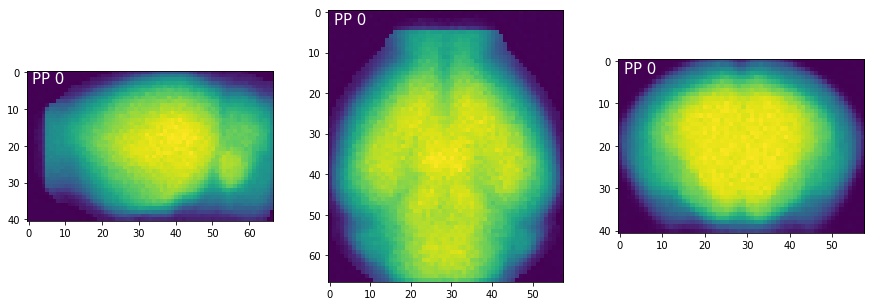

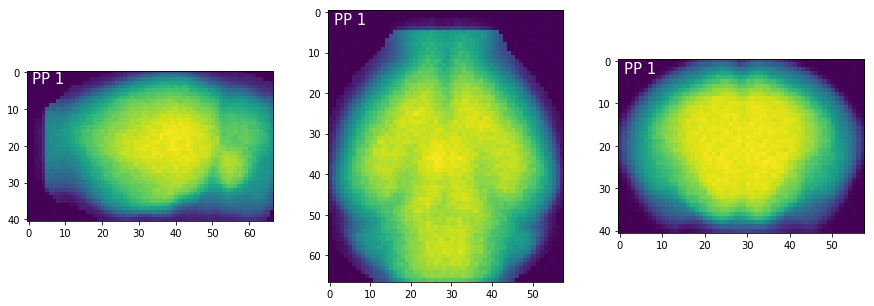

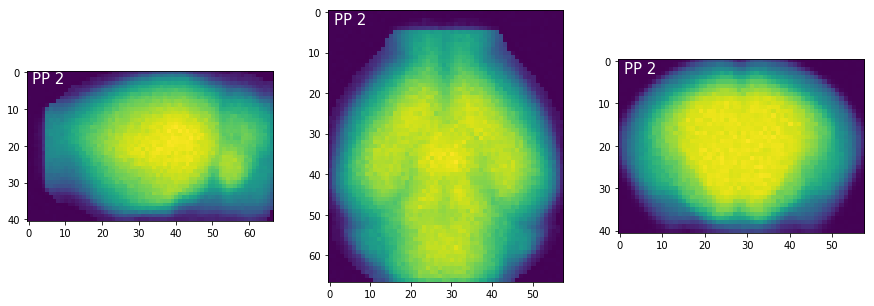

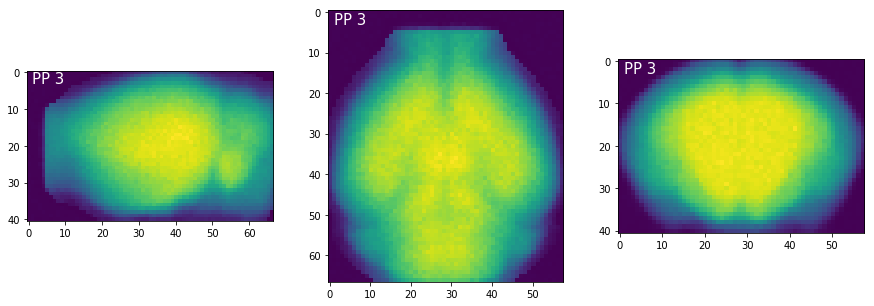

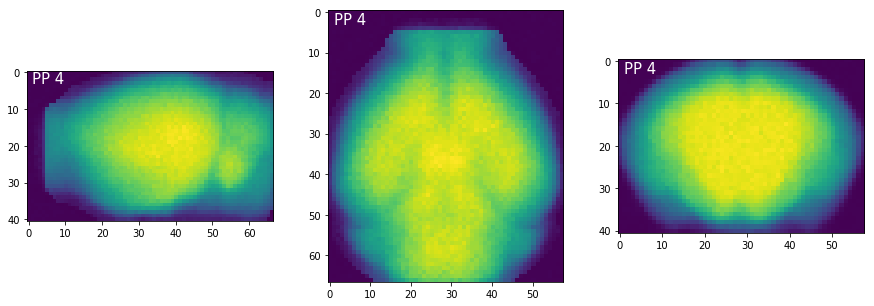

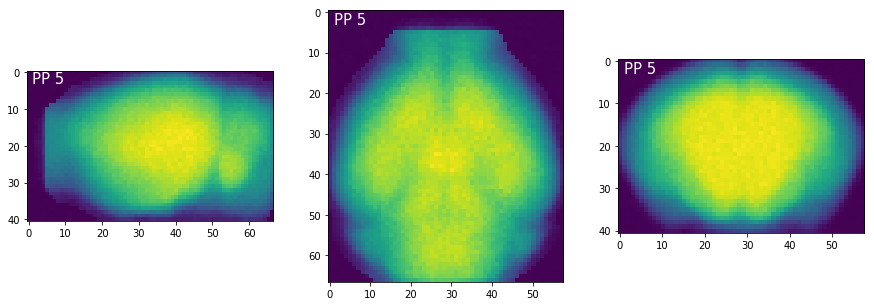

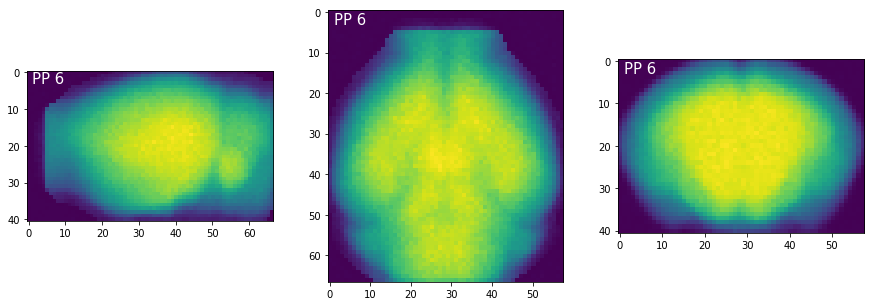

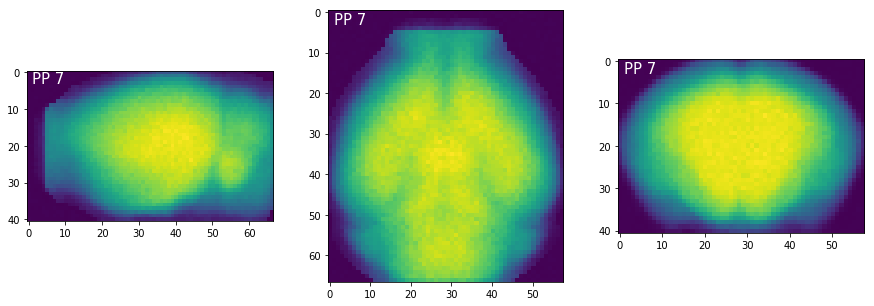

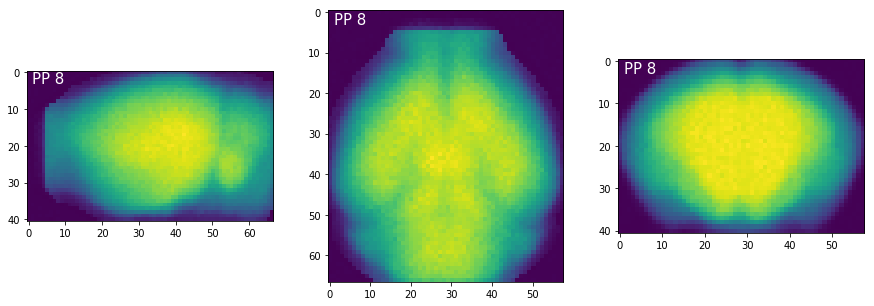

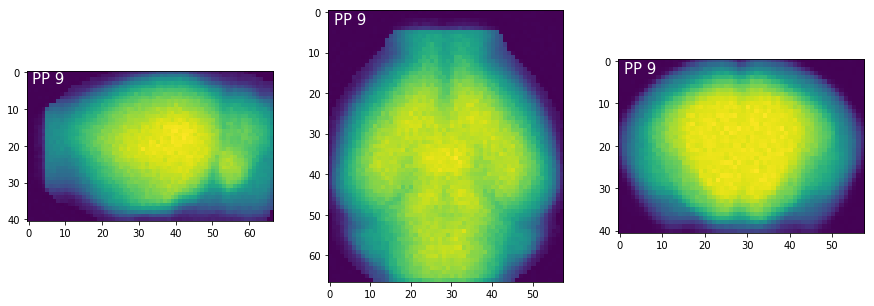

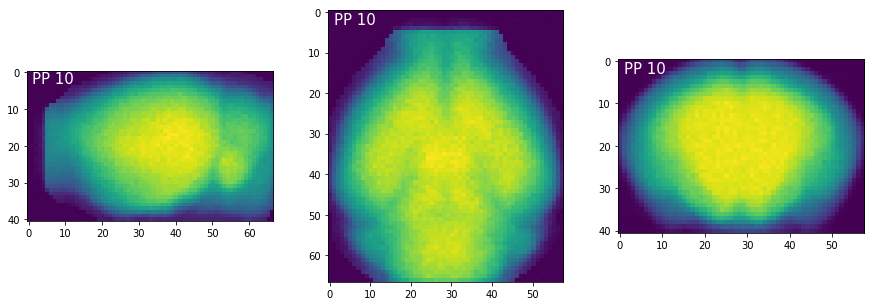

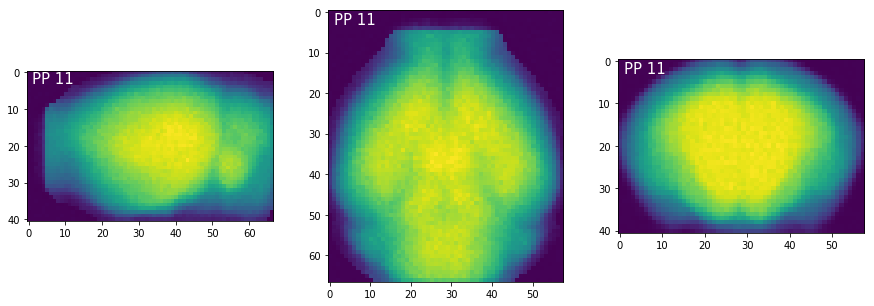

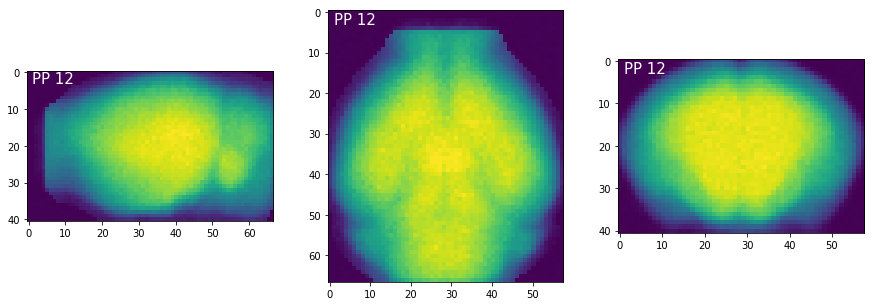

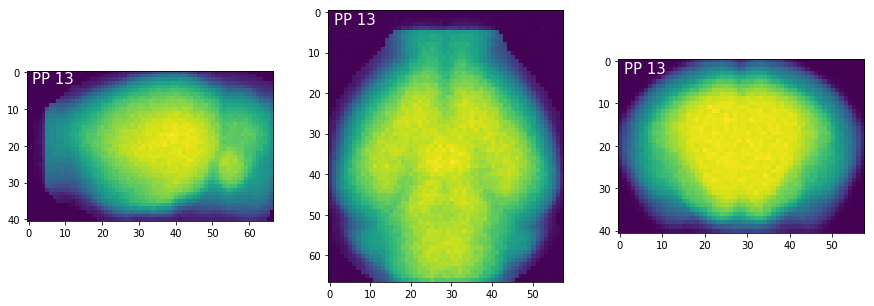

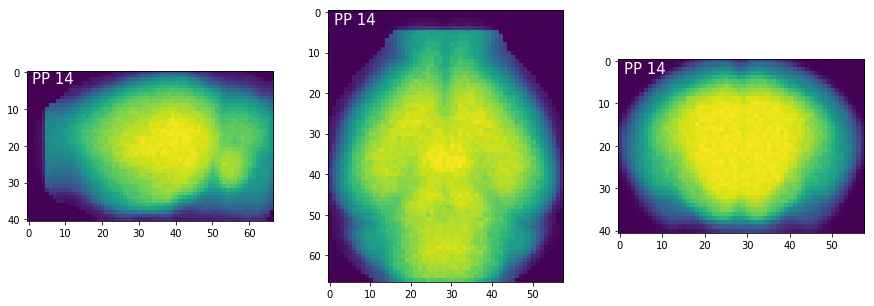

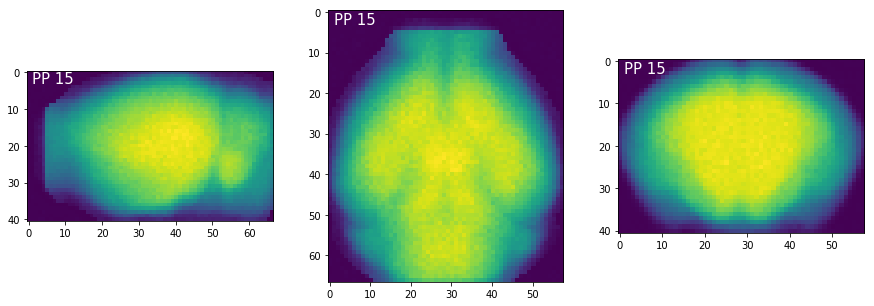

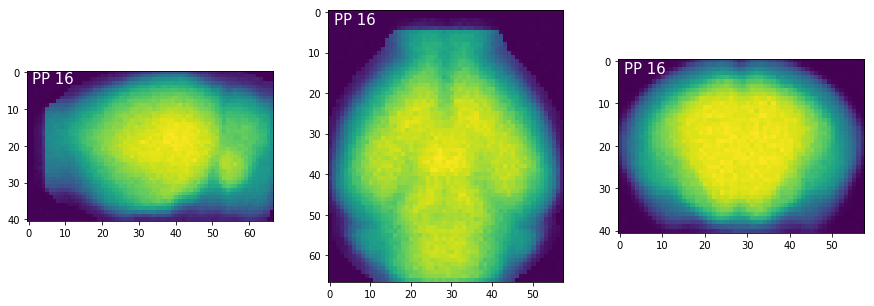

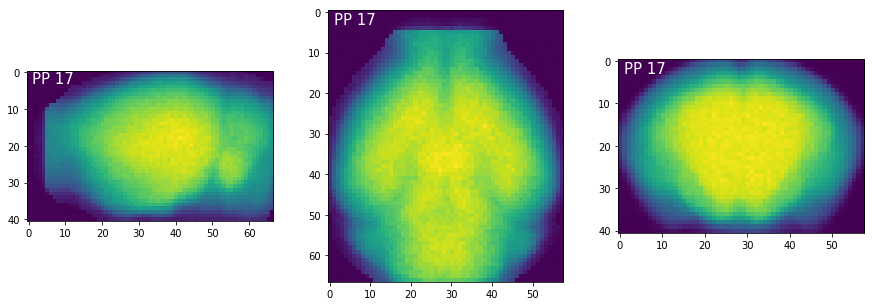

In [24]:
#visualize patterns
for i in range(18):
    _, (a, b, c) = plt.subplots(1, 3, figsize=(15, 5))
    a.imshow(np.mean(PPs[i, :, :, :], 2).T)
    b.imshow(np.mean(PPs[i, :, :, :], 1))
    c.imshow(np.mean(PPs[i, :, :, :], 0))
    a.text(1, 3, 'PP {}'.format(i), color='w', fontsize=15)
    b.text(1, 3, 'PP {}'.format(i), color='w', fontsize=15)
    c.text(1, 3, 'PP {}'.format(i), color='w', fontsize=15)

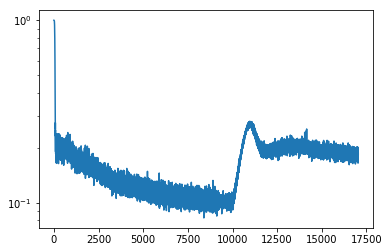

In [110]:
#visualize the objective_during_training
plt.plot(obj_during_training[0:])
plt.yscale('log')

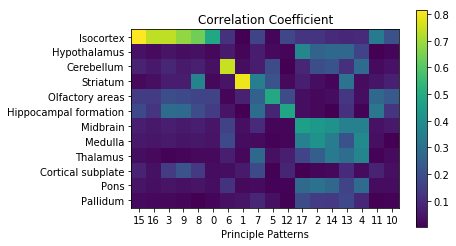

In [111]:
#visualize the correlation with the reference map
corr_mat = correlation_map_with_CCF(PPs, np.array(original_shape), order_type=2,area_order=[1,9,3,11,4,8,0,2,10,5,6,7], put_last_k=2)

In [86]:
#store_model
np.savez("../data/03_autoencoder_result.npz", PPs = PPs)